In [1]:
import os
import copy
import datasets as ds
import FPMLmodule.utils as utils
import tensorflow as tf
import FPMLmodule.backbones as backbones
import FPMLmodule.classifiers as classifiers
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from FPMLmodule.fpml import FPML 
from pathlib import Path

print('TensorFlow Version:', tf.__version__)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

TensorFlow Version: 2.8.0


In [2]:
weightsRN50 = "./weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsMNV2 = "./weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
weightsENB2 = "./weights/efficientnetb2_notop.h5"
weightsINCEPTIONV3 = "./weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weightsXCEPTION = "./weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [3]:
def ablation(configureDS, datasets, imgDim,epochsSearch, epochsBest, path, optimizers, learningRates, hypers, losses, backboneForTypeMode, verbose=1):
    trainDs, testDs, valDs = datasets
    nbClasses = len(configureDS.classNames)
    activation = "softmax"
    outFilePath = path + 'ablationHistory.csv'
    
    trainingModeStudy =  {
        'DNN-TransferLearningMode' : {
            "architecture": {
                "backbone": [
                    backboneForTypeMode(imgDim, weights=weightsMNV2, trainable=False, name=backboneForTypeMode.__name__+'PT&Untrainable')#,
                    # backboneForTypeMode(imgDim, weights=weightsMNV2, trainable=True, name=backboneForTypeMode.__name__+'PT&Trainable'),
                    # backboneForTypeMode(imgDim, weights=None, trainable=True, name=backboneForTypeMode.__name__+'IN&Trainable')
                    ],
                "classfier": classifiers.DefaultClassifier(nbClasses, activation),
                "inputLayer": None, 
                "inputDim": imgDim
            },
            "hyperparameters":hypers
        }
    }
    trainingModeHistories = utils.researchStudies(trainDs, valDs, trainingModeStudy, epochsSearch, verbose)
    trainingModeBestModel = utils.getBestStudyFromHistories(trainingModeHistories)
    trainable = 'Trainable' in trainingModeBestModel
    pretrained = 'PT' in trainingModeBestModel
    utils.displayStudiesProgress(trainingModeHistories, path, 'Training Mode Comparison')
    utils.saveStudyHistory(trainingModeStudy, trainingModeHistories, outFilePath)

    print("Training Mode Selected - Pretrained:", pretrained, 'Trainable:', trainable)

    # Backbone
    bestBackboneStudy = {
        "bestBackbone" : {
            "architecture": {
                "backbone": [
                    backbones.ResNet50(imgDim, weights=weightsRN50, trainable=trainable)#,
                    # backbones.EfficientNetB2(imgDim, weights=weightsENB2, trainable=trainable),
                    # backbones.InceptionV3(imgDim, weights=weightsINCEPTIONV3, trainable=trainable),
                    # backbones.Xception(imgDim, weights=weightsXCEPTION, trainable=trainable)
                    ],
                "classfier": classifiers.DefaultClassifier(nbClasses, activation),
                "inputLayer":"", 
                "inputDim": imgDim
            },
            "hyperparameters": hypers
        },
    }
    bestBackboneHistories = utils.researchStudies(trainDs, valDs, bestBackboneStudy, epochsSearch, verbose)
    bestBackboneHistories[trainingModeBestModel] = trainingModeHistories[trainingModeBestModel]
    bestBackbone = utils.getBestStudyFromHistories(bestBackboneHistories)
    utils.displayStudiesProgress(bestBackboneHistories, path, 'Best Backbone Comparison')
    utils.saveStudyHistory(bestBackboneStudy, bestBackboneHistories, outFilePath)
    print("Best DNN Backbon:", bestBackbone)


    # Optimizer
    optimizersStudy = copy.deepcopy(bestBackboneHistories[bestBackbone]['config'])
    optimizersStudy["hyperparameters"]["optimizer"] = optimizers
    optimizersHistories = utils.researchStudies(trainDs, valDs, {bestBackbone : optimizersStudy}, epochsSearch, verbose)
    optimizersHistories[bestBackbone+"_Adam"] = bestBackboneHistories[bestBackbone]
    bestOptimizier = utils.getBestStudyFromHistories(optimizersHistories)
    utils.displayStudiesProgress(optimizersHistories, path, 'Optimizer Comparison')
    utils.saveStudyHistory({bestBackbone: optimizersStudy}, optimizersHistories, outFilePath)
    print("Best Optimizier:", bestOptimizier)


    # Learning rate
    learningRatesStudy = copy.deepcopy(optimizersHistories[bestOptimizier]['config'])
    learningRatesStudy['hyperparameters']['learningRate'] = learningRates
    learningRatesHistories = utils.researchStudies(trainDs, valDs, {bestOptimizier: learningRatesStudy}, epochsSearch, verbose)
    learningRatesHistories[bestOptimizier+"_"+str(hypers["learningRate"])] = optimizersHistories[bestOptimizier]
    bestLearningRate = utils.getBestStudyFromHistories(learningRatesHistories)
    utils.displayStudiesProgress(learningRatesHistories, path, 'Learning Rate Comparison')
    utils.saveStudyHistory({bestOptimizier: learningRatesStudy}, learningRatesHistories, outFilePath)
    print("Best Learning Rate:", bestLearningRate)
    
    # loss function
    lossStudy = copy.deepcopy(learningRatesHistories[bestLearningRate]['config'])
    lossStudy['hyperparameters']["loss"] = losses
    lossesHistories = utils.researchStudies(trainDs, valDs, {bestLearningRate: lossStudy}, epochsSearch, verbose)
    lossesHistories[bestLearningRate+"_"+str(hypers["loss"])] = learningRatesHistories[bestLearningRate]
    bestLoss = utils.getBestStudyFromHistories(lossesHistories)
    utils.saveStudyHistory({bestLearningRate: lossStudy}, lossesHistories, outFilePath)
    print(bestLoss)

    bestModelName = bestLoss
    bestModelConfiguration = lossesHistories[bestLoss]['config']
    trainValDs = trainDs.concatenate(valDs)
    
    bestModel = FPML(**bestModelConfiguration["architecture"]).create(**bestModelConfiguration["hyperparameters"])
    bestModelHistory = bestModel.fit(trainValDs, validation_data=testDs, epochs=epochsBest, verbose=verbose)
    toSave = {'Best Model':{'history' : bestModelHistory, 'config' : bestModelConfiguration}}
    utils.displayStudiesProgress(toSave, path, 'Best Model')
    utils.saveStudyHistory({'Best Model': bestModelConfiguration}, toSave, outFilePath)
    bestModel.save(path+configureDS.name+'_'+bestModelName+".h5")
    
    
    utils.displayConfusion(testDs, bestModel, path)

optimizers=[Nadam, RMSprop]
learningRates = [0.1, 0.01, 0.0001, 0.00001]
defaultHypers = {
        "optimizer": Adam,
        "learningRate": 0.001,
        "loss": 'binary_crossentropy',
        "metrics": 'accuracy'
    }
losses = ['binary_focal_crossentropy', 'hinge']
backboneForTypeMode = backbones.MobileNetV2



In [4]:
# Global Config
seed=9
imgDim = (120, 120, 3)
imgHeight, imgWidth, imgChannels = imgDim
batchSize = 32
verbose = 1
outDir = './testOut/'

# Dataset configuration
dsConfig = {
    'batchSize': batchSize, 
    'parallelTune': tf.data.AUTOTUNE, 
    'split': [0.7, 0.15, 0.15], 
    'inputDim': (120, 120, 3), 
    'seed': seed, 
    'shuffle': True
    }
# Training interval
epochsForSearch = 2
epochsForBest = 2

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



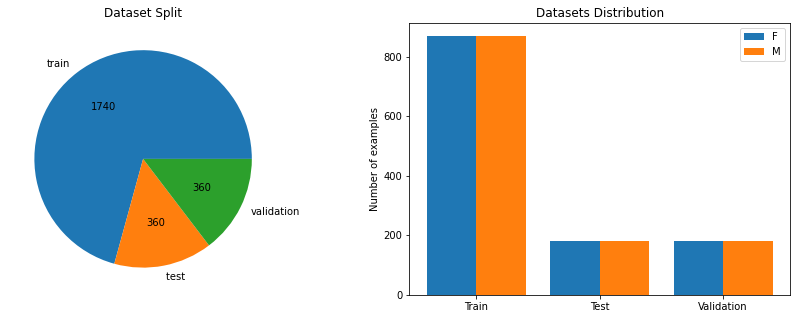

Epoch 1/3
55/55 [==============================] - 10s 98ms/step - loss: 0.8791 - accuracy: 0.5563 - val_loss: 0.6779 - val_accuracy: 0.5833
Epoch 2/3
55/55 [==============================] - 3s 61ms/step - loss: 0.6956 - accuracy: 0.5937 - val_loss: 0.6733 - val_accuracy: 0.5861
Epoch 3/3
55/55 [==============================] - 3s 59ms/step - loss: 0.6549 - accuracy: 0.6385 - val_loss: 0.6732 - val_accuracy: 0.6083
Training Mode Selected - Pretrained: True Trainable: False
Epoch 1/3
55/55 [==============================] - 12s 142ms/step - loss: 1.0936 - accuracy: 0.5207 - val_loss: 0.6848 - val_accuracy: 0.5750
Epoch 2/3
55/55 [==============================] - 4s 80ms/step - loss: 0.7225 - accuracy: 0.5793 - val_loss: 0.6615 - val_accuracy: 0.6250
Epoch 3/3
55/55 [==============================] - 4s 80ms/step - loss: 0.6752 - accuracy: 0.6259 - val_loss: 0.6836 - val_accuracy: 0.5972
Best DNN Backbon: MobileNetPT&Untrainable0
Epoch 1/3
55/55 [==============================] - 12s 

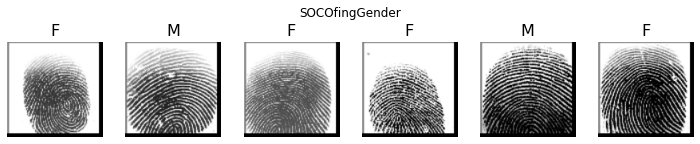

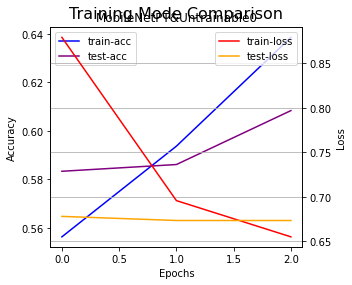

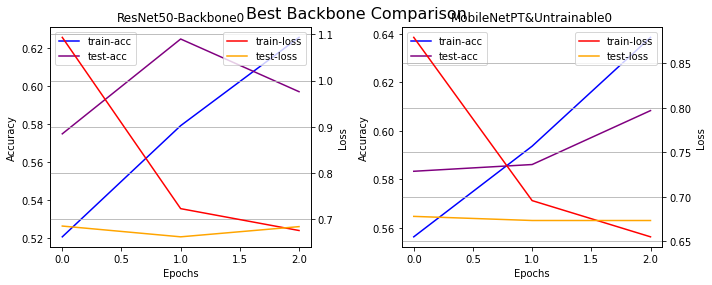

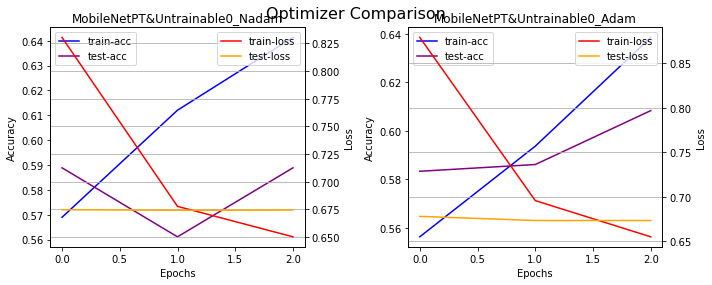

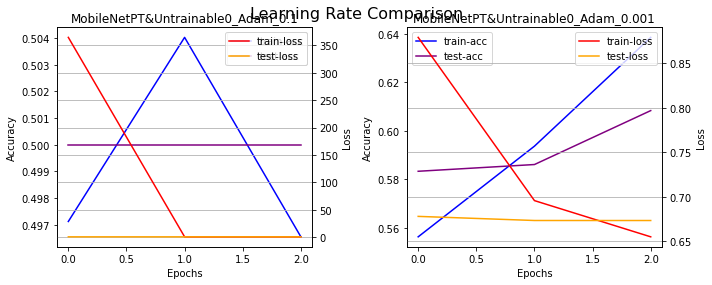

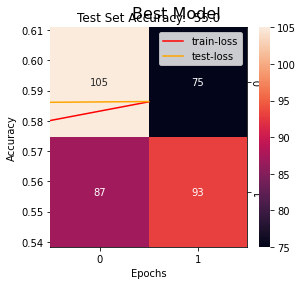

In [5]:


configureDS = ds.SOCOFingGender(**dsConfig, sampling=ds.SOCOFingGender.UNDER_SAMPLING)
datasets = configureDS.create()
dbStudyOutPath = outDir+'/'+configureDS.name+'/'
Path(dbStudyOutPath).mkdir(parents=True, exist_ok=True)
utils.datasetAnalysisAndDisplay(datasets, configureDS, dbStudyOutPath)

SOCOFingGenderConfig = {
    'configureDS': configureDS,
    'datasets': datasets,
    'imgDim': imgDim,
    'epochsSearch': epochsForSearch,
    'epochsBest': epochsForBest,
    'path': dbStudyOutPath+'/',
    'optimizers': optimizers[:1],
    'learningRates': learningRates[:1],
    'losses': losses[:1],
    'hypers': defaultHypers,
    'backboneForTypeMode': backboneForTypeMode,
    'verbose': 1
}

ablation(**SOCOFingGenderConfig)

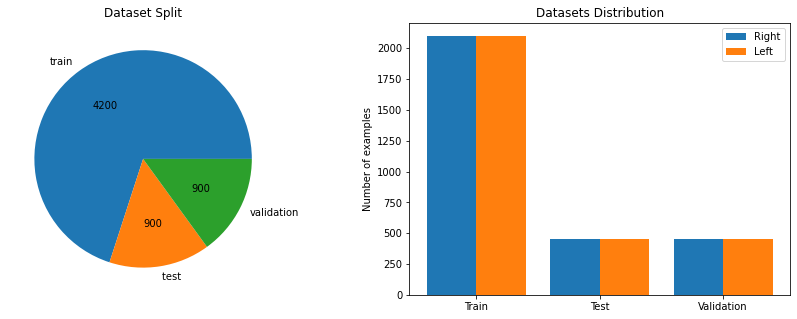

Epoch 1/3
132/132 [==============================] - 14s 79ms/step - loss: 0.6812 - accuracy: 0.6548 - val_loss: 0.6403 - val_accuracy: 0.6156
Epoch 2/3
132/132 [==============================] - 8s 59ms/step - loss: 0.5173 - accuracy: 0.7429 - val_loss: 0.5764 - val_accuracy: 0.6600
Epoch 3/3
132/132 [==============================] - 8s 60ms/step - loss: 0.4721 - accuracy: 0.7719 - val_loss: 0.4740 - val_accuracy: 0.7911
Training Mode Selected - Pretrained: True Trainable: False
Epoch 1/3
132/132 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.5886

KeyboardInterrupt: 

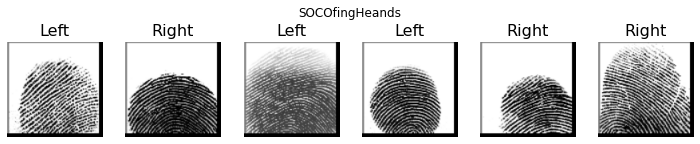

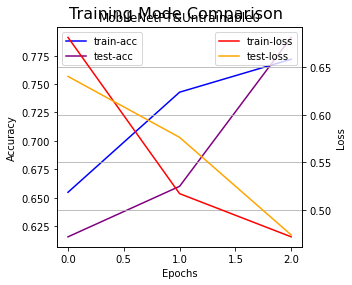

In [6]:


Dataset = ds.SOCOFingHeands
configureDS = ds.SOCOFingHeands(**dsConfig)
datasets = configureDS.create()
dbStudyOutPath = outDir+'/'+configureDS.name+'/'
Path(dbStudyOutPath).mkdir(parents=True, exist_ok=True)
utils.datasetAnalysisAndDisplay(datasets, configureDS, dbStudyOutPath)

SOCOFingHeandsConfig = {
    'configureDS': configureDS,
    'datasets': datasets,
    'imgDim': imgDim,
    'epochsSearch': epochsForSearch,
    'epochsBest': epochsForBest,
    'path': dbStudyOutPath+'/',
    'optimizers': optimizers[:1],
    'learningRates': learningRates[:1],
    'losses': losses[:1],
    'hypers': defaultHypers,
    'backboneForTypeMode': backboneForTypeMode,
    'verbose': 1
}
ablation(**SOCOFingHeandsConfig)
